# Names (Enter your names below)
Student 1 Name and JHED: Yuanwei Xu (yxu105)

Student 2 Name and JHED (If applicable):  ...

#Tasks#




**(a)** Read the paper (Liu et al., 2019) to familiarize yourself with the problem and the approach to be followed.

**(b)** [30 points] Train a generalized linear model (i.e., logistic regression) on the normalized data with lasso penalty ($l_1$) (Friedman et al., 2010). You may use
any appropriate libraries (e.g. sklearn.linear model.SGDClassifier with
balanced class weights from scikit-learn (Pedregosa et al., 2011)). Plot the
ROC curve and display the AUC.

**(c)** [30 points] Refine this model by determining an optimal regularization value $\lambda \geqslant 0$ which maximizes AUC via cross-validation as described in (Liu et al.,
2019). It is suggested that you use a stochastic optimization strategy by splitting your dataset into smaller chunks that you feed to the optimizer. Then display your optimal $\lambda$.

**(d)** [40 points] Evaluate the ROC curve on the testing data using your optimal $\lambda$ and compute the operating point (the point closest to (0,1)) corresponding to the optimal threshold as defined in (Liu et al., 2019). Plot the obtained ROC curve overlaying the operating point and its associated sensitivity (TPR) and specificity (1 - FPR). Also add the Area Under the Curve (AUC) value to the figure.

**(e)** [Bonus 10 points] Using the timestamp data, generate a histogram of Early Warning Time (EWT) values on the test data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as date
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

# fix random number generator for reproducibility
np.random.seed(0)

# Read Data

In [2]:
#===========================================
# Read data.  Change DATAPATH if necessary
#===========================================
try:
    # Executes if running in Google Colab
    from google.colab import drive
    drive.mount('gdrive/')
    DATAPATH = "gdrive/My Drive/DS4BME/Lab3" # Change path to location of data if necessary
except:
    # Executes if running locally (e.g. Anaconda)
    DATAPATH = "./"

# Read training data
traindata = pd.read_csv('/'.join((DATAPATH,'glm.training.data.csv')))
X = traindata.iloc[:,1:29].values # Rows are patients, columns are clinical indicators
y = traindata.iloc[:,-1].values

# Read testing data
testdata = pd.read_csv('/'.join((DATAPATH,'glm.test.data.csv')))
Xtest = testdata.iloc[:,1:29].values
ytest = testdata.iloc[:,-1].values

Mounted at gdrive/


In [3]:
testdata.tail()

,Unnamed: 0,hr,sbp,dbp,mbp,resp,temp,cvp,pao2,fio2,gcs,bili,platelets,creat,lactate,bun,ph,wbc,paco2,hgb,hct,potassium,urine,resp.sofa,nervous.sofa,cardio.sofa,liver.sofa,coag.sofa,kidney.sofa,patient,y
1302373,1302374,82.0,98.0,84.0,87.0,14.0,37.164892,15.309346,478.0,100.0,15.0,0.7,234.0,1.6,1.0,31.0,7.47,7.9,36.0,9.6,21.0,5.9,0.0,1,0,1.10508,0,0,1,6737,1
1302374,1302375,82.0,98.0,84.0,87.0,14.0,37.164892,15.309346,208.0,100.0,15.0,0.7,234.0,1.6,3.0,31.0,7.37,7.9,45.0,9.6,23.0,4.6,0.0,2,0,1.10508,0,0,1,6737,1
1302375,1302376,82.0,98.0,84.0,87.0,14.0,37.164892,15.309346,208.0,100.0,15.0,0.7,178.0,1.6,3.0,31.0,7.37,7.9,45.0,9.6,23.0,4.6,0.0,2,0,1.10508,0,0,1,6737,1
1302376,1302377,82.0,98.0,84.0,87.0,16.0,37.164892,15.309346,208.0,100.0,15.0,0.7,178.0,1.6,3.0,31.0,7.37,7.9,45.0,9.6,23.0,4.6,0.0,2,0,1.10508,0,0,1,6737,1
1302377,1302378,82.0,98.0,84.0,87.0,16.0,37.164892,15.309346,208.0,100.0,15.0,0.7,178.0,1.6,3.0,31.0,7.37,7.9,45.0,9.6,23.0,4.6,325.0,2,0,1.10508,0,0,1,6737,1


In [71]:
print(testdata.shape)

(1302378, 31)


# Train generalized linear model (i.e. logistic regression)

**(b)** [30 points] Train a generalized linear model (i.e., logistic regression) on the normalized data with lasso penalty ( $𝑙_1$ ) (Friedman et al., 2010). You may use any appropriate libraries (e.g. sklearn.linear model.SGDClassifier with balanced class weights from scikit-learn (Pedregosa et al., 2011)). Plot the ROC curve and display the AUC.

In [4]:
# Normalize Training (zero mean, unity standard deviation)
X  = X-np.mean(X,axis=0)
X  = X/np.std(X,axis=0)

# Normalize Testing Data.
Xtest  = Xtest - np.mean(Xtest,axis=0)
Xtest  = Xtest/np.std(Xtest,axis=0)

[[1128302  187398]
 [  37398  223102]]
              precision    recall  f1-score   support

           0       0.97      0.86      0.91   1315700
           1       0.54      0.86      0.66    260500

    accuracy                           0.86   1576200
   macro avg       0.76      0.86      0.79   1576200
weighted avg       0.90      0.86      0.87   1576200



Text(0.5, 1.0, 'ROC Curve for training data with AUC: 0.922617214324509')

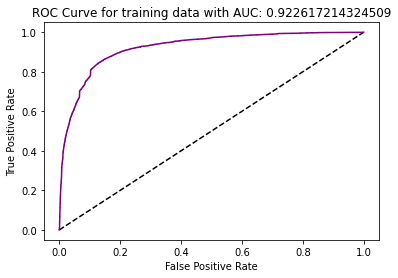

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
# Create the classifier: model
model = SGDClassifier(loss="log", penalty="l1", alpha = 0.0001, max_iter=1000, class_weight = "balanced")

# Fit the classifier to the training data
model.fit(X, y)

# Predict the labels of the training set: y_pred
ypred = model.predict(X)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y, ypred))
print(classification_report(y, ypred))
# Compute predicted probabilities: ypred_prob
ypred_prob = model.predict_proba(X)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y, ypred_prob)

# Plot ROC curve for testing data
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color = 'purple')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for training data with AUC: {}'.format(auc(fpr,tpr)))

# Refine the model

**(c)** [30 points] Refine this model by determining an optimal regularization value $\lambda \geqslant 0$ which maximizes AUC via cross-validation as described in (Liu et al.,
2019). It is suggested that you use a stochastic optimization strategy by splitting your dataset into smaller chunks that you feed to the optimizer. Then display your optimal $\lambda$.

In [6]:
'''
for each 10-fold cross-validation we go through alpha = np.logspace(-6, 1, num=10)
'''
# Define alphas
alphas = np.logspace(-6, 1, num=10)

# Construct 
auc_list = np.zeros((len(alphas), len(alphas)))

# Kfold : 10 fold splitting
kf = KFold(n_splits=10, random_state=1, shuffle=True)

index =0
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for i in range(len(alphas)):
      model = SGDClassifier(loss="log", penalty="l1", alpha = alphas[i] , max_iter=1000, class_weight = "balanced")
      model.fit(X_train, y_train)
      y_train_pred = model.predict_proba(X_train)[:,1]
      fpr, tpr, thr =roc_curve(y_train, y_train_pred)
      auc_list[index][i] = auc(fpr,tpr)
    index += 1
print(auc_list)     


TRAIN: [      0       1       2 ... 1576197 1576198 1576199] TEST: [      5      13      21 ... 1576184 1576187 1576192]
TRAIN: [      0       1       2 ... 1576197 1576198 1576199] TEST: [      8       9      24 ... 1576181 1576186 1576191]
TRAIN: [      1       2       4 ... 1576197 1576198 1576199] TEST: [      0       3      16 ... 1576169 1576188 1576194]
TRAIN: [      0       1       2 ... 1576197 1576198 1576199] TEST: [      6       7      12 ... 1576152 1576160 1576190]
TRAIN: [      0       1       2 ... 1576196 1576197 1576198] TEST: [     10      17      33 ... 1576189 1576193 1576199]
TRAIN: [      0       1       3 ... 1576197 1576198 1576199] TEST: [      2      14      20 ... 1576134 1576136 1576138]
TRAIN: [      0       1       2 ... 1576197 1576198 1576199] TEST: [     11      15      28 ... 1576161 1576180 1576185]
TRAIN: [      0       2       3 ... 1576197 1576198 1576199] TEST: [      1       4      25 ... 1576167 1576170 1576177]
TRAIN: [      0       1       2 

In [13]:
print(alphas)

[1.00000000e-06 5.99484250e-06 3.59381366e-05 2.15443469e-04
 1.29154967e-03 7.74263683e-03 4.64158883e-02 2.78255940e-01
 1.66810054e+00 1.00000000e+01]


In [21]:
# Identifying optimal lambda 
opti_auc_array = np.max(auc_list, axis = 1) 
opti_auc_argarray = np.argmax(auc_list, axis = 1) 
opti_auc_arg = np.argmax(opti_auc_array)
opti_alpha = alphas[opti_auc_arg]
print("The optimal lambda(alpha) is,", opti_alpha)



The optimal lambda(alpha) is, 5.994842503189409e-06


# ROC curve on Testing data

**(d)** [40 points] Evaluate the ROC curve on the **testing data** using your optimal  𝜆  and compute the operating point (the point closest to (0,1)) corresponding to the optimal threshold as defined in (Liu et al., 2019). Plot the obtained ROC curve overlaying the operating point and its associated sensitivity (TPR) and specificity (1 - FPR). Also add the Area Under the Curve (AUC) value to the figure.

[[563565 623115]
 [ 61352  54346]]
              precision    recall  f1-score   support

           0       0.90      0.47      0.62   1186680
           1       0.08      0.47      0.14    115698

    accuracy                           0.47   1302378
   macro avg       0.49      0.47      0.38   1302378
weighted avg       0.83      0.47      0.58   1302378



Text(0.5, 1.0, 'ROC Curve for testing data with AUC: 0.44010060321009215')

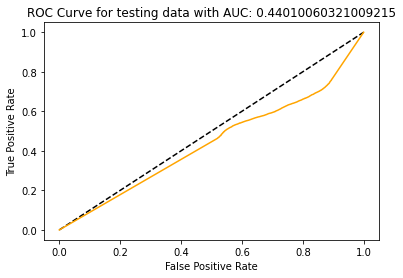

In [41]:
# Create the classifier with the optimal lambda(alpha): opti_model
opti_model = SGDClassifier(loss="log", penalty="l1", alpha = opti_alpha, max_iter=1000, class_weight = "balanced")

# Fit the classifier to the training data
opti_model.fit(X, y)

# Predict the labels of the testing set: ytest_pred
ytest_pred = opti_model.predict(Xtest)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(ytest, ytest_pred))
print(classification_report(ytest, ytest_pred))
# Compute predicted probabilities: ytest_pred_prob
ytest_pred_prob = opti_model.predict_proba(Xtest)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(ytest, ytest_pred_prob)

# Plot ROC curve for testing data
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color = 'Orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for testing data with AUC: {}'.format(auc(fpr,tpr)))



[0.         0.46172795 0.46186624 ... 0.76436066 0.76437795 1.        ]
[0.         0.51865035 0.51879951 ... 0.89654077 0.89654077 1.        ]
[2.00000000e+000 1.00000000e+000 1.00000000e+000 ... 5.57364222e-309
 5.56320582e-309 0.00000000e+000]
0.44010060321009215
Operating threshold value is: 3.006070836866612e-65
Operating TPR value(sensitivity) is: 0.5085826894155474
Operating (1-FPR) value(specificity) is: 0.44978005865102644


Text(0.5, 1.0, 'ROC Curve for testing data with AUC: 0.44010060321009215')

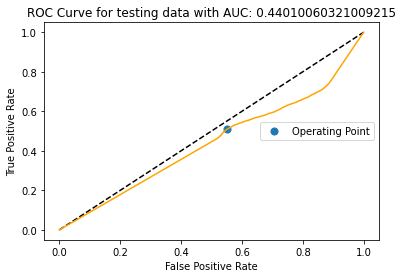

In [49]:
from sklearn.metrics import roc_auc_score
print(tpr)
print(fpr)
print(thresholds)
print(roc_auc_score(ytest, ytest_pred_prob))

optimal_idx = np.argmin((tpr-1)**2+fpr**2)
optimal_threshold = thresholds[optimal_idx]
optimal_tpr = tpr[optimal_idx]
optimal_fpr = fpr[optimal_idx]
print("Operating threshold value is:", optimal_threshold)
print("Operating TPR value(sensitivity) is:", optimal_tpr)
print("Operating (1-FPR) value(specificity) is:", 1-optimal_fpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(optimal_fpr, optimal_tpr, s = 50, label = 'Operating Point')
plt.legend(loc = 'center right')
plt.plot(fpr, tpr, color = 'Orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for testing data with AUC: {}'.format(auc(fpr,tpr)))

# Early Warning Time (Bonus)

**(e)** [Bonus 10 points] Using the timestamp data, generate a histogram of Early Warning Time (EWT) values on the test data.

In [70]:
print(len(ytest))

1302378


In [82]:
# Loading timestamp data
timestamps = pd.read_csv('/'.join((DATAPATH,'test.timestamps.csv')))['x'].values
timeonset  = pd.read_csv('/'.join((DATAPATH,'test.onsets.csv')))['onsets'].values
timestamps_df = pd.read_csv('/'.join((DATAPATH,'test.timestamps.csv')))
timeonset_df  = pd.read_csv('/'.join((DATAPATH,'test.onsets.csv')))
timeonset_df.sort_values(by=['onsets'], axis=0, ascending=True)

,Unnamed: 0,onsets,subjects
757,758,2100-09-08 08:27:00,253527
121,122,2100-09-18 18:20:00,249669
1055,1056,2100-09-29 03:54:00,206577
329,330,2101-04-16 19:15:00,249146
1043,1044,2101-06-13 15:00:00,240163
...,...,...,...
198,199,2202-02-27 14:14:00,203466
245,246,2202-04-14 17:15:00,252746
651,652,2202-09-24 23:54:00,291628
631,632,2205-01-17 01:00:00,280951


In [196]:
timestamps_dff = timestamps_df.sort_values(by=['x'], axis=0, ascending=True)
timestamps_dff = timestamps_dff.reset_index()
del timestamps_dff['index']
timestamps_dff['x'] = pd.to_datetime(timestamps_dff['x'])
timestamps_dff.head(1515)

,Unnamed: 0,x
0,538618,2100-06-09 01:18:00
1,538619,2100-06-09 02:00:00
2,538620,2100-06-09 02:40:00
3,538621,2100-06-09 03:00:00
4,538622,2100-06-09 04:00:00
...,...,...
1510,1264041,2100-09-08 06:00:00
1511,1264042,2100-09-08 07:00:00
1512,1264043,2100-09-08 08:00:00
1513,1264044,2100-09-08 08:06:00


In [157]:
timeonset_dff = timeonset_df.sort_values(by=['onsets'], axis=0, ascending=True)
timeonset_dff = timeonset_dff.reset_index()
del timeonset_dff['index']
timeonset_dff['onsets'] = pd.to_datetime(timeonset_dff['onsets'])
timeonset_dff.head()

,Unnamed: 0,onsets,subjects
0,758,2100-09-08 08:27:00,253527
1,122,2100-09-18 18:20:00,249669
2,1056,2100-09-29 03:54:00,206577
3,330,2101-04-16 19:15:00,249146
4,1044,2101-06-13 15:00:00,240163


In [141]:
timeonset_dff.shape

(1114, 3)

In [139]:
timestamps_list = timestamps_dff["x"].tolist()
onsets_list = timeonset_dff["onsets"].tolist()

unique_index = pd.Index(timestamps_list)
onset_index = unique_index.get_loc(onsets_list[0])

startTime = timestamps_dff.x.loc[0] 
endTime = timestamps_dff.x.loc[onset_index] 
EWT = endTime - startTime
print(EWT)

91 days 07:09:00


In [189]:
# Identify the index for onset time in timestamps 
onset_id = []
for i in range(len(onsets_list)):
  onsetid = timestamps_list.index(onsets_list[i])
  onset_id.append(onsetid)

print(onset_id)

[1514, 1752, 1821, 5211, 6439, 8687, 11388, 11483, 11794, 14570, 16928, 17696, 17726, 18764, 18909, 20140, 20229, 20527, 22534, 24305, 25836, 25919, 33203, 33604, 34615, 34619, 35045, 36003, 36143, 36189, 36265, 36435, 37584, 39513, 41579, 42730, 43776, 43928, 45635, 46371, 47245, 47260, 48105, 50431, 51822, 52775, 53994, 55058, 55066, 59587, 63370, 64659, 64811, 65543, 65598, 65689, 66405, 67383, 69340, 69510, 71406, 71672, 73812, 73829, 74078, 74155, 74264, 77860, 78029, 80414, 80984, 82010, 82757, 84758, 86639, 87290, 87779, 88129, 88368, 88427, 88662, 89268, 89519, 92490, 96473, 98307, 99950, 100474, 102499, 106222, 108085, 108789, 109094, 109309, 110026, 111761, 111824, 114394, 116257, 116656, 117442, 118699, 119851, 120222, 121587, 123472, 124006, 124529, 126450, 127225, 127972, 129753, 129827, 131552, 132075, 132896, 133071, 133393, 133723, 133813, 134595, 134722, 138099, 138188, 138517, 138988, 140146, 140251, 141896, 145610, 146472, 146510, 146890, 146908, 147203, 153873, 1553

In [190]:
# Construct index list for elapse starting time
start_id = [x+1 for x in onset_id]
start_id.insert(0,0) # Manually insert the starting index 0
del start_id[-1] # deleting the last index

print(start_id)

[0, 1515, 1753, 1822, 5212, 6440, 8688, 11389, 11484, 11795, 14571, 16929, 17697, 17727, 18765, 18910, 20141, 20230, 20528, 22535, 24306, 25837, 25920, 33204, 33605, 34616, 34620, 35046, 36004, 36144, 36190, 36266, 36436, 37585, 39514, 41580, 42731, 43777, 43929, 45636, 46372, 47246, 47261, 48106, 50432, 51823, 52776, 53995, 55059, 55067, 59588, 63371, 64660, 64812, 65544, 65599, 65690, 66406, 67384, 69341, 69511, 71407, 71673, 73813, 73830, 74079, 74156, 74265, 77861, 78030, 80415, 80985, 82011, 82758, 84759, 86640, 87291, 87780, 88130, 88369, 88428, 88663, 89269, 89520, 92491, 96474, 98308, 99951, 100475, 102500, 106223, 108086, 108790, 109095, 109310, 110027, 111762, 111825, 114395, 116258, 116657, 117443, 118700, 119852, 120223, 121588, 123473, 124007, 124530, 126451, 127226, 127973, 129754, 129828, 131553, 132076, 132897, 133072, 133394, 133724, 133814, 134596, 134723, 138100, 138189, 138518, 138989, 140147, 140252, 141897, 145611, 146473, 146511, 146891, 146909, 147204, 153874, 1

In [191]:
EWT = []
for i in range(timeonset_dff.shape[0]):
  startTime = timestamps_dff.x.loc[start_id[i]] 
  endTime = timestamps_dff.x.loc[onset_id[i]]
  ewt = endTime - startTime
  EWT.append(ewt)

print(EWT)

[Timedelta('91 days 07:09:00'), Timedelta('8 days 10:30:00'), Timedelta('10 days 08:54:00'), Timedelta('197 days 06:45:00'), Timedelta('57 days 19:00:00'), Timedelta('53 days 06:15:00'), Timedelta('37 days 20:08:00'), Timedelta('8 days 11:30:00'), Timedelta('7 days 08:30:00'), Timedelta('54 days 17:00:00'), Timedelta('31 days 23:20:00'), Timedelta('9 days 17:44:00'), Timedelta('0 days 05:49:00'), Timedelta('15 days 13:45:00'), Timedelta('1 days 17:21:00'), Timedelta('12 days 19:37:00'), Timedelta('10 days 13:45:00'), Timedelta('1 days 13:23:00'), Timedelta('61 days 12:30:00'), Timedelta('50 days 09:52:00'), Timedelta('61 days 10:13:00'), Timedelta('1 days 12:00:00'), Timedelta('268 days 11:32:00'), Timedelta('5 days 01:00:00'), Timedelta('35 days 07:30:00'), Timedelta('0 days 00:12:00'), Timedelta('16 days 19:11:00'), Timedelta('10 days 08:30:00'), Timedelta('1 days 05:30:00'), Timedelta('8 days 17:46:00'), Timedelta('2 days 10:24:00'), Timedelta('3 days 17:30:00'), Timedelta('25 days 

In [224]:
ewt_secs=timeonset_dff.EWT.dt.total_seconds() 
ewt_secs_list = ewt_secs.tolist()
ewt_hrs = [j/3600 for j in ewt_secs_list]
timeonset_dff['EWT in hours'] = ewt_hrs
timeonset_dff.head()

,Unnamed: 0,onsets,subjects,EWT,EWT in hours
0,758,2100-09-08 08:27:00,253527,91 days 07:09:00,2191.15
1,122,2100-09-18 18:20:00,249669,8 days 10:30:00,202.50
2,1056,2100-09-29 03:54:00,206577,10 days 08:54:00,248.90
3,330,2101-04-16 19:15:00,249146,197 days 06:45:00,4734.75
4,1044,2101-06-13 15:00:00,240163,57 days 19:00:00,1387.00


Text(0, 0.5, 'Frequency')

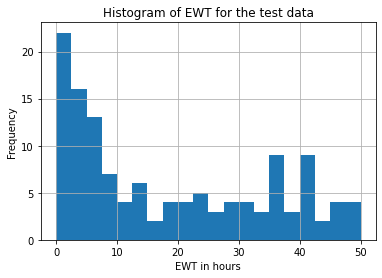

In [240]:
timeonset_dff.hist(column='EWT in hours', bins = 20, range=[0, 50])
plt.title('Histogram of EWT for the test data')
plt.xlabel('EWT in hours')
plt.ylabel('Frequency')
